In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': (12, 6)}, style='whitegrid')

from scipy import stats as st
import statsmodels.formula.api as smf

from datetime import timedelta

### Знакомство с данными

In [4]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/426638/test2_completed.csv', parse_dates=['Дата'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Дата           14 non-null     datetime64[ns]
 1   Число заказов  14 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


In [6]:
df.duplicated().any()

False

In [7]:
df.rename(columns={"Дата": 'date', "Число заказов": 'orders'}, inplace=True)
df.head()

,date,orders
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


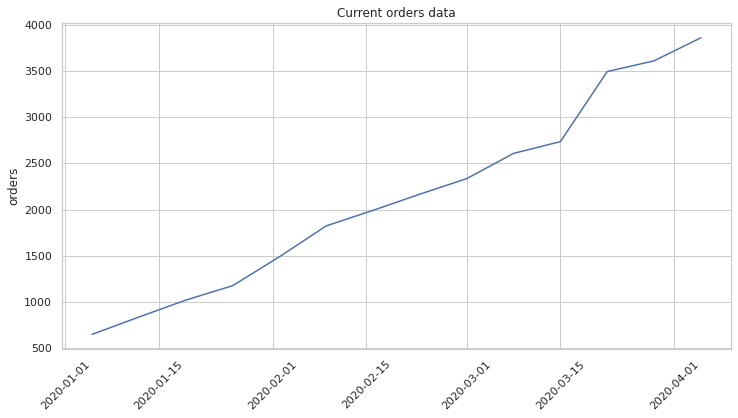

In [8]:
sns.lineplot(x=df.date, y=df.orders)
plt.title('Current orders data')
plt.xticks(rotation=45)
plt.xlabel('') ;

In [9]:
# Уменьшаем количество заказов с учётом акции

df.loc[5, 'orders'] = df.loc[5, 'orders']*0.93

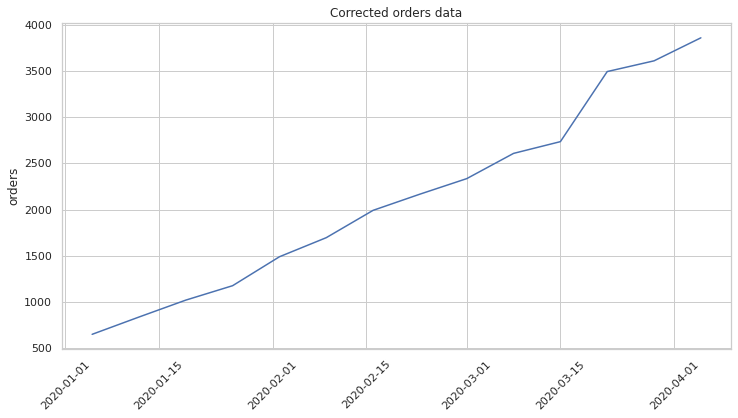

In [10]:
sns.lineplot(x=df.date, y=df.orders)
plt.title('Corrected orders data')
plt.xticks(rotation=45)
plt.xlabel('') ;

### Предсказание с использованием линейной регрессии

In [11]:
# даты в обычной регрессии использовать нельзя, поэтому создаём новую фичу - номер недели

df['num_of_week'] = df.index + 1

In [12]:
df.tail()

,date,orders,num_of_week
9,2020-03-08,2607.0,10
10,2020-03-15,2734.0,11
11,2020-03-22,3492.0,12
12,2020-03-29,3608.0,13
13,2020-04-05,3857.0,14


In [13]:
# одно значение оставим для грубой оценки точности модели

model_df_reg = df.loc[:len(df)-2, :]
model_df_reg

,date,orders,num_of_week
0,2020-01-05,650.00,1
1,2020-01-12,837.00,2
2,2020-01-19,1020.00,3
3,2020-01-26,1176.00,4
4,2020-02-02,1489.00,5
5,2020-02-09,1695.39,6
6,2020-02-16,1991.00,7
7,2020-02-23,2166.00,8
8,2020-03-01,2334.00,9
9,2020-03-08,2607.00,10


In [14]:
# обучение модели

model = smf.ols('orders ~ num_of_week', model_df_reg).fit()

In [15]:
model.summary()

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 orders   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     528.9
Date:                Wed, 16 Jun 2021   Prob (F-statistic):           1.19e-10
Time:                        17:40:19   Log-Likelihood:                -81.867
No. Observations:                  13   AIC:                             167.7
Df Residuals:                      11   BIC:                             168.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     279.4681     84.069      3.324      0.007      94.434     464.502
num_of_week   243.5858     10.592     22.998      0.000     220.274     266.898
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   1.466
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.557
Skew:                           0.503   Prob(JB):                        0.757
Kurtosis:                       2.863   Cond. No.                         17.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Модель объясняет 97,8% процентов изменчивости зависимой величины
# полученные коэффициенты - взаимосвязи НП и ЗП 243.5858; интерсепт 279.4681

In [17]:
def reg_prediction(x):
    return 243.5858 * x + 279.4681

In [18]:
print('Prediction:', round(reg_prediction(14), 0), '(targeet value 3857.00) -', round(reg_prediction(14)/3857*100, 2),'%')

Prediction: 3690.0 (targeet value 3857.00) - 95.66 %


### Обработка результата

In [19]:
prediction_dates = []
add_date = df.date.max()

for _ in range(13):
    add_date += timedelta(days=7)
    prediction_dates.append(add_date)

In [20]:
predicted_df_reg = pd.DataFrame({'date': prediction_dates, 'num_of_week': range(15, 15+len(prediction_dates))})

In [21]:
predicted_df_reg['orders'] = round(reg_prediction(predicted_df_reg.num_of_week), 0)

In [22]:
predicted_df_reg

,date,num_of_week,orders
0,2020-04-12,15,3933.0
1,2020-04-19,16,4177.0
2,2020-04-26,17,4420.0
3,2020-05-03,18,4664.0
4,2020-05-10,19,4908.0
5,2020-05-17,20,5151.0
6,2020-05-24,21,5395.0
7,2020-05-31,22,5638.0
8,2020-06-07,23,5882.0
9,2020-06-14,24,6126.0


In [23]:
regression_df = pd.concat([df, predicted_df_reg]).reset_index()
regression_df.tail()

,index,date,orders,num_of_week
22,8,2020-06-07,5882.0,23
23,9,2020-06-14,6126.0,24
24,10,2020-06-21,6369.0,25
25,11,2020-06-28,6613.0,26
26,12,2020-07-05,6856.0,27


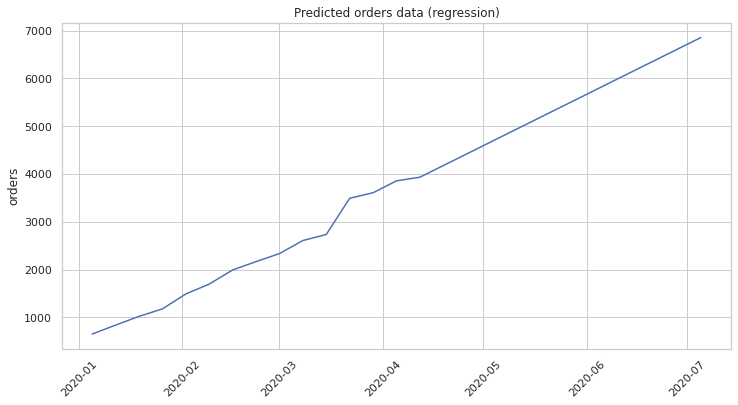

In [24]:
sns.lineplot(x=regression_df.date, y=regression_df.orders)
plt.title('Predicted orders data (regression)')
plt.xticks(rotation=45)
plt.xlabel('') ;

### Prophet

In [25]:
# Специальный алгоритм, используемый для анализа временных рядов
# Позволяет учитывать сезонность различных уровней

In [26]:
from datetime import date
import holidays
from fbprophet import Prophet

In [27]:
df.head()

,date,orders,num_of_week
0,2020-01-05,650.0,1
1,2020-01-12,837.0,2
2,2020-01-19,1020.0,3
3,2020-01-26,1176.0,4
4,2020-02-02,1489.0,5


In [28]:
df_prophet = df.drop(['num_of_week'], axis=1).rename(columns={'date': 'ds', 'orders': 'y'})

In [29]:
df_prophet.tail()

,ds,y
9,2020-03-08,2607.0
10,2020-03-15,2734.0
11,2020-03-22,3492.0
12,2020-03-29,3608.0
13,2020-04-05,3857.0


In [30]:
holidays_dict = holidays.RU(years=(2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays.rename(columns={'index': 'ds', 0: 'holiday'}, inplace=True)
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
#df_holidays = df_holidays.sort_values(by=['ds'])

In [31]:
df_holidays.tail()

,ds,holiday
9,2020-03-08,День женщин
10,2020-05-01,Праздник Весны и Труда
11,2020-05-09,День Победы
12,2020-06-12,День России
13,2020-11-04,День народного единства


In [32]:
# одно значение не используем в обучении для дальнейшей оценки качества модели

model_df_prophet = df_prophet.loc[:len(df_prophet)-2]
model_df_prophet.tail()

,ds,y
8,2020-03-01,2334.0
9,2020-03-08,2607.0
10,2020-03-15,2734.0
11,2020-03-22,3492.0
12,2020-03-29,3608.0


In [33]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(model_df_prophet)

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


In [34]:
# прогноз 1 значения

test_future = m.make_future_dataframe(periods=1)
test_forecast = m.predict(test_future)

In [35]:
print('Prediction:', round(test_forecast['yhat'][13], 0), '(target value 3857.00) -', round(test_forecast['yhat'][13]/3857*100, 2),'%')

Prediction: 3535.0 (target value 3857.00) - 91.66 %


In [36]:
# полученное значение сильнее отличается от целевого, чем в случае регрессии

In [37]:
# Обучаем prophet на всех данных и делаем прогноз на 3 месяца

m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(df_prophet)

future = m.make_future_dataframe(periods=91)
forecast = m.predict(future)

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


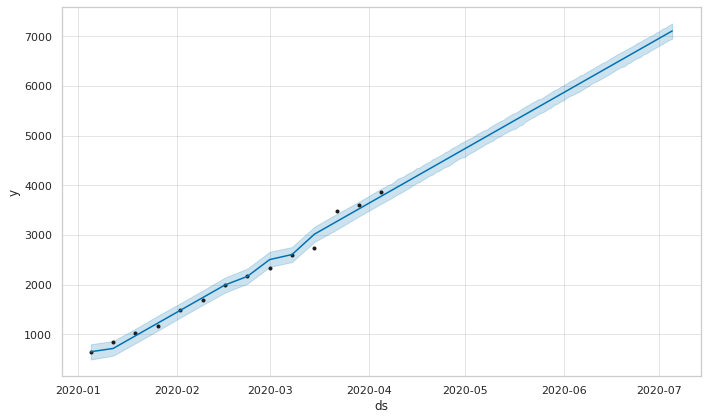

In [38]:
m.plot(forecast);

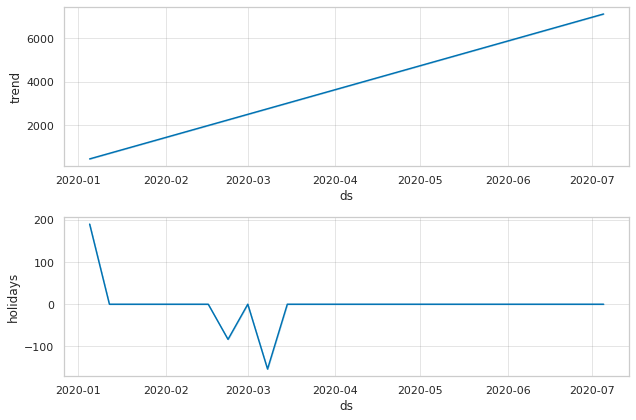

In [39]:
m.plot_components(forecast);

# продажи увеличиваются линейно
# в праздники происходит падение заказов (23 февраля в меньшей степени, 8 марта - в большей)

In [40]:
prophet_df = forecast[['ds', 'yhat']]
prophet_df.tail()  # датафрейм с предсказанными заказами

,ds,yhat
100,2020-07-01,6962.149539
101,2020-07-02,6998.684445
102,2020-07-03,7035.219351
103,2020-07-04,7071.754257
104,2020-07-05,7108.289163


In [41]:
# добавляем для каждой даты номер недели и группируем по нему
# чтобы получить предсказанное среднее количество заказов за неделю

prophet_df['num_of_week'] = forecast.ds.dt.isocalendar().week
prophet_df = prophet_df.groupby('num_of_week').agg({'ds': np.max, 'yhat': np.mean}).reset_index()
prophet_df.yhat = prophet_df.yhat.round(0)
prophet_df.tail()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,num_of_week,ds,yhat
22,23,2020-06-07,5976.0
23,24,2020-06-14,6231.0
24,25,2020-06-21,6487.0
25,26,2020-06-28,6743.0
26,27,2020-07-05,6999.0


In [44]:
np.mean(regression_df.orders - prophet_df.yhat)    # в среднем prophet прогнозирует большее число заказов, чем регрессия

-33.43

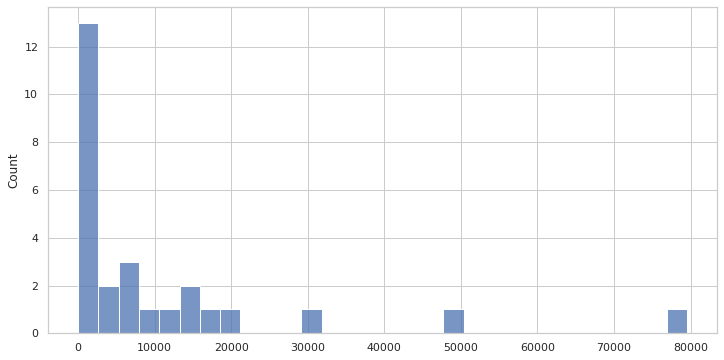

In [45]:
# распределение разниц между значениями, предсказанными регрессией и профетом

sns.histplot([i*i for i in (regression_df.orders - prophet_df.yhat)], bins = 30);

In [46]:
# объединяем предсказания в один датафрейм

predictions = regression_df.merge(prophet_df, on='num_of_week')

In [47]:
predictions = predictions.drop(['index', 'ds'], axis=1).rename(columns={'yhat': 'prophet_pred', 'orders': 'regression_pred'})

In [48]:
predictions

,date,regression_pred,num_of_week,prophet_pred
0,2020-01-05,650.00,1,650.0
1,2020-01-12,837.00,2,716.0
2,2020-01-19,1020.00,3,971.0
3,2020-01-26,1176.00,4,1227.0
4,2020-02-02,1489.00,5,1483.0
5,2020-02-09,1695.39,6,1738.0
6,2020-02-16,1991.00,7,1994.0
7,2020-02-23,2166.00,8,2166.0
8,2020-03-01,2334.00,9,2505.0
9,2020-03-08,2607.00,10,2607.0


### Выводы
Было проведено предсказание числа заказов за неделю с использованием модели линейной регрессии с одним предиктором и FBprophet

Безусловно, предсказание величины на ближайшие 3 месяца на основе данных только за 3 предыдущих - совсем условное предсказание ввиду отсутствия достаточного количества данных для учёта различных сезонностей (например, годовой или систематического увеличения заказов в, к примеру, июне по какой-либо причине)

Полученный прогноз описывает ожидаемую динамику продаж при сохранении в следующие 3 месяца тех же трендов в поведении поведении пользователей, что и 3 месяца ранее (что, как было описано выше, является довольно сильным приближнением)

Для более релевантного прогноза необходимо большее количество данных

В данных присутствует тенденция - снижение спроса 23 февраля и 8 марта

При сравнении регрессии и fbprophet получилось, что профет даёт в целом более оптимистичный прогноз, при обучении с использованием последнего значения для валидации прогноз регрессии оказался более точен, но небольшое количество данных вряд ли позволяет говорить о качественом превосходстве регрессионной модели